# Solution to ShAI_BootCamp_Assignment

In [67]:
# Importing necessary modules

import pandas as pd
import numpy as np

df = pd.read_csv("./Salaries.csv")
# read `Salaries` dataset

### 1. Basic Data Exploration: Identify the number of rows and columns in the dataset, determine the data types of each column, and check for missing values in each column.

Since `df` uses the default 0-based pandas's indexing method, we can get the # rows by getting the last index + 1.

In [68]:
print(f"Total # of rows: {df.index[-1] + 1}\nTotal # of columns: {len(df.columns)}")

Total # of rows: 148654
Total # of columns: 13


#### Types of each column:

In [69]:
print(df.columns)

Index(['Id', 'EmployeeName', 'JobTitle', 'BasePay', 'OvertimePay', 'OtherPay',
       'Benefits', 'TotalPay', 'TotalPayBenefits', 'Year', 'Notes', 'Agency',
       'Status'],
      dtype='object')


**Id**: unique identifier (nominal).

**EmployeeName**, **JobTitle**: nominal.

**BasePay**, **OvertimePay**, **OtherPay**, **Benefits**, **TotalPay**, **TotalPayBenefits**: continuous, seince they contains a fractions.

**Year**: discrete.

**Notes**, **Status**: null values, they represent missing or undefined values, they could be nominal.

**Agency**: nominal.

#### Checking for missing values:

In [70]:
columns_with_mv = df.isna().any()
columns_with_mv.name = "Columns with missing values"
print(columns_with_mv)

Id                  False
EmployeeName        False
JobTitle            False
BasePay              True
OvertimePay          True
OtherPay             True
Benefits             True
TotalPay            False
TotalPayBenefits    False
Year                False
Notes                True
Agency              False
Status               True
Name: Columns with missing values, dtype: bool


 ### 2. Calculate basic statistics mean, median, mode, minimum, and maximum salary, determine the range of salaries, and find the standard deviation.

- Descriptive stat. for numerical attributes:

In [71]:
print(df.drop(columns=["Id"]).describe(include=["number"])) # Excluding the identifier column, and provide a description for numerical columns.

             BasePay    OvertimePay       OtherPay       Benefits  \
count  148045.000000  148650.000000  148650.000000  112491.000000   
mean    66325.448840    5066.059886    3648.767297   25007.893151   
std     42764.635495   11454.380559    8056.601866   15402.215858   
min      -166.010000      -0.010000   -7058.590000     -33.890000   
25%     33588.200000       0.000000       0.000000   11535.395000   
50%     65007.450000       0.000000     811.270000   28628.620000   
75%     94691.050000    4658.175000    4236.065000   35566.855000   
max    319275.010000  245131.880000  400184.250000   96570.660000   

            TotalPay  TotalPayBenefits           Year  Notes  Status  
count  148654.000000     148654.000000  148654.000000    0.0     0.0  
mean    74768.321972      93692.554811    2012.522643    NaN     NaN  
std     50517.005274      62793.533483       1.117538    NaN     NaN  
min      -618.130000       -618.130000    2011.000000    NaN     NaN  
25%     36168.995000   

- Descriptive stat. for categorical attributes:

In [72]:
print(df.describe(include=["object"])) # A description for other nonnumerical columns.

       EmployeeName          JobTitle         Agency
count        148654            148654         148654
unique       110811              2159              1
top       Kevin Lee  Transit Operator  San Francisco
freq             13              7036         148654


### 3. Handle missing data by suitable method with explain why you use it.

Well, there are many methods and techniques to deal with missing values, and the most appropriate thing to consider when dealing with missing values is to go back to our stakeholders and ask them how to deal with these missing values.

Let's take a closer look at the missing data, to see the appropriate way to handle each one:

In [73]:
df.loc[:, columns_with_mv].isna().sum() # The number of missing values in each column.

BasePay           609
OvertimePay         4
OtherPay            4
Benefits        36163
Notes          148654
Status         148654
dtype: int64

Assuming that all missing values are missing completely at random(MCAR) or missing at random(MAR), we can:

- **Row/Column Deletion**:
  This has some repercussions, such as loss of information, impact on statistical calculations, and, of course, it will introduce bias. So, this method is feasible only when large datasets are available, and missing values occur only in a small percentage relative to the dataset size, like in case of `OvertimePay`, `OtherPay` and `BasePay`.

In [74]:
df.dropna(subset=["OvertimePay", "OtherPay"], inplace=True)

    For both `Notes` and `Status` null columns, it may be reasonable to consider removing them, as they do not provide meaningful information for analysis.

In [75]:
df.drop(columns=["Status", "Notes"], inplace=True)

- **Imputation**:
  Imputation involves filling in missing data, typically done by using measures like the mean, median, mode, neighboring values, or predictive modeling techniques.

  When dealing with missing values, it's important to be keep in mind the potential biases introduced by using the mean, especially when a large number of values are missing (e.g. useing the mean for impute missing values in the `Benefits` column), as this could skew the central tendency of the data and lead to inaccuracies. 
  
  In such cases, choosing the median can offer a more robust representation, especially as it is not influenced by outliers. While it's a common practice to calculate subgroup means/medians for imputation, but for simplicity, I'll use the overall mean/median. Additionally, for categorical attributes, relying on the mode is generally the recommended approach.

  The decision between mean and median depends on various factors, one of which involves **assessing skewness**. For example, when examining the skewness of the `BasePay` column and finding a skewness value of approximately 0.42—indicating a nearly symmetric distribution—the choice between mean and median for handling missing values becomes more easy. Given the almost symmetrical nature of the distribution,choosing for the mean to substitute missing values is a suitable choice.

In [76]:
print("β = {0:.2}".format(df["BasePay"].skew()))
df["BasePay"].fillna(df["BasePay"].mean(), inplace=True)

β = 0.42


    Finally, let's handle the missing values in the `Benefits` column of our dataset. Since the number of missing values is relatively large compared to the total size, traditional imputation methods like using the mean or median might not be suitable. Instead, employing the linear regression algorithm seems promising.
    It assumes a linear relationship between the target variable and the other features. By training a linear regression model on the instances where the Benefits column is not missing, we can use this model to predict and impute the missing values based on the observed relationships in the data. This makes it a suitable choice for our scenario.

In [77]:
# Import necessary modules from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a Linear Regression model
model = LinearRegression()

# Split the dataset into two subsets: one with non-missing "Benefits" values and one with missing values
df_not_missing, df_missing = (
    df.loc[df["Benefits"].notna(), df.columns.difference(["Id", "EmployeeName", "Agency", "Year"])],
    df.loc[df["Benefits"].isna(), df.columns.difference(["Id", "EmployeeName", "Agency", "Benefits", "Year"])]
)

# Encode the "JobTitle" column by replacing each job title with its frequency count in both subsets (categorical values encoded based on their occurrences for modeling purposes)
df_not_missing.loc[:, "JobTitle"] = df_not_missing["JobTitle"].map(df_not_missing["JobTitle"].value_counts().to_dict())
df_missing.loc[:, "JobTitle"] = df_missing["JobTitle"].map(df_missing["JobTitle"].value_counts().to_dict())

# Split the non-missing subset into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(df_not_missing.drop(columns=["Benefits"]), df_not_missing.Benefits)

# Standardize the feature values in both training and testing sets (Z-Score normalization)
xtrain = xtrain.sub(xtrain.mean()).div(xtrain.std())
xtest = xtest.sub(xtest.mean()).div(xtest.std())

# Fit the Linear Regression model to the training data
model.fit(xtrain, ytrain)

# Make predictions on the testing set
ypredict = model.predict(xtest)

# Calculate and print the Mean Squared Error (MSE) as a measure of model performance
print("MSE = {0:.2}".format(mean_squared_error(ytest, ypredict)))


MSE = 3.4e+03


In [78]:
# Standardize the features in the 'df_missing' subset using mean and standard deviation
df_missing = df_missing.sub(df_missing.mean()).div(df_missing.std())

# Predict 'Benefits' values for the missing subset using the trained linear regression model
ypredict = model.predict(df_missing)

# Create a DataFrame with predicted 'Benefits' values, preserving the original index
cleaned_benefits = pd.DataFrame(ypredict, index=df_missing.index, columns=["Benefits"])

# Combine the original DataFrame ('df') with the DataFrame of predicted 'Benefits', filling missing values
df = df.combine_first(cleaned_benefits)


Quick check:

In [79]:
df.isna().any()

Agency              False
BasePay             False
Benefits            False
EmployeeName        False
Id                  False
JobTitle            False
OtherPay            False
OvertimePay         False
TotalPay            False
TotalPayBenefits    False
Year                False
dtype: bool

Well, the absence of detailed information regarding data sources, coupled with a lack of guidance on managing missing values and distinguishing between correct and incorrect data values, complicates the data cleaning process. 

Please, refer to *doi* research papers below for more information about how I deal with this task:  
10.20470/JSI.V5I1.178  
10.1111/j.1741-3737.2005.00191

or follow these links:  
https://rb.gy/wjiwmb <br>
https://rb.gy/le1m0o




### 4. **Basic Data Visualization**: Create histograms or bar charts to visualize the distribution of salaries, and use pie charts to represent the proportion of employees in different departments.

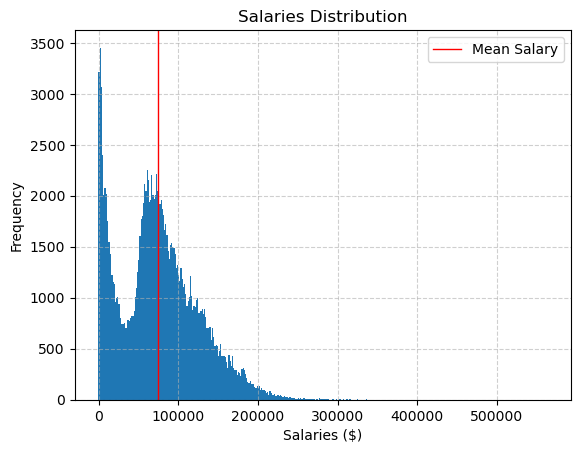

In [80]:
import matplotlib.pyplot as plt 

# Determine the number of bins for the histogram using the square root rule
k = int(np.ceil((df.index[-1] + 1) ** 0.5))

# Calculate the minimum and maximum values of the 'TotalPay' column
min_salary, max_salary = df.TotalPay.min(), df.TotalPay.max()

# Calculate the range (R) and class length for histogram bins
R = max_salary - min_salary
class_length = np.ceil(R / k)

# Define the bin edges (classes, or cut points) based on the calculated class length
classes = [min_salary + class_length * (j - 1) for j in range(k)]

# Plot the histogram of 'TotalPay' with specified bins
plt.hist(df.TotalPay, bins=classes)

plt.title("Salaries Distribution")
plt.ylabel("Frequency")
plt.xlabel("Salaries ($)")

# Add gridlines for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Add a vertical line representing the mean salary with a label
plt.axvline(df.TotalPay.mean(), color='red', linestyle='-', linewidth=1, label='Mean Salary')

# Display legend for the added line
plt.legend()

plt.show()


Since there is no explicit department column in the provided dataset, I've opt to use the 'JobTitle' column to infer departmental information.  
However, since there are 2158 unique JobTitles, visualizing each individual title in a pie chart would be overwhelming and lack meaningful insight.  
Thus, the decision is made to prioritize clarity and focus on the top N departments, where N is adjustable, based on employee count

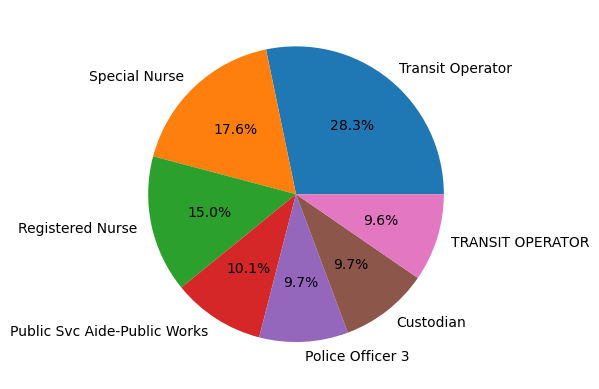

In [81]:
# Set the number of top departments to display in the pie chart
TOP_LARGEST_NDEPARTMENT = 7

# Extract and count the occurrences of each job title in the 'JobTitle' column
top_departments = df['JobTitle'].value_counts().nlargest(TOP_LARGEST_NDEPARTMENT)

# Plot a pie chart representing the distribution of the top job titles
plt.pie(top_departments, labels=top_departments.index, startangle=0, autopct="%1.1f%%")

plt.show()

### 5. Grouped Analysis Group the data by one or more columns and calculate summary statistics for each  group, and compare the average salaries across different groups.


In [82]:
grouped_by_year = df.groupby('Year')
grouped_by_job_title = df.groupby('JobTitle')
grouped_by_year_job_title = df.groupby(['Year', 'JobTitle'])

# Define a dictionary of aggregate functions for specific columns
aggregate_functions = {
    'BasePay': 'mean',
    'OvertimePay': ['max', 'min'],
    'OtherPay': ['max', 'min'],
    'TotalPay': ['mean', 'max'],
    'TotalPayBenefits': 'sum',
    'JobTitle': 'count'
}

grouped_by_year.aggregate(aggregate_functions)


BasePay OvertimePay         OtherPay               TotalPay  \
              mean         max   min        max      min          mean   
Year                                                                     
2011  63595.956517   245131.88  0.00  400184.25     0.00  71744.103871   
2012  65436.406857   220909.48  0.00  245999.41     0.00  74113.262265   
2013  69576.866579   196689.18 -0.01  202322.37 -7058.59  77611.443142   
2014  66564.421924   173547.73  0.00  342802.63  -618.13  75471.836912   

                TotalPayBenefits JobTitle  
            max              sum    count  
Year                                       
2011  567595.43     2.594195e+09    36159  
2012  362844.66     3.696940e+09    36766  
2013  347102.32     3.814772e+09    37606  
2014  471952.64     3.821866e+09    38119

In [83]:
grouped_by_job_title.aggregate(aggregate_functions)

BasePay OvertimePay       \
                                                        mean         max  min   
JobTitle                                                                        
ACCOUNT CLERK                                   43300.806506    10753.06  0.0   
ACCOUNTANT                                      46643.172000        0.00  0.0   
ACCOUNTANT INTERN                               28732.663958      624.84  0.0   
ACPO,JuvP, Juv Prob (SFERS)                     62290.780000        0.00  0.0   
ACUPUNCTURIST                                   66374.400000        0.00  0.0   
...                                                      ...         ...  ...   
X-RAY LABORATORY AIDE                           47664.773077    23016.22  0.0   
X-Ray Laboratory Aide                           46086.387100    29239.96  0.0   
YOUTH COMMISSION ADVISOR, BOARD OF SUPERVISORS  52609.910000        0.00  0.0   
Youth Comm Advisor                              39077.957500        0.00  0.0   
ZOO CURATOR                                     43148.000000        0.00  0.0   

                                                OtherPay            \
                                                     max       min   
JobTitle                                                             
ACCOUNT CLERK                                    3370.13      0.00   
ACCOUNTANT                                       2782.08      0.00   
ACCOUNTANT INTERN                                3069.19      0.00   
ACPO,JuvP, Juv Prob (SFERS)                         0.00      0.00   
ACUPUNCTURIST                                    1220.00   1220.00   
...                                                  ...       ...   
X-RAY LABORATORY AIDE                            5643.93    200.00   
X-Ray Laboratory Aide                            7916.20      0.00   
YOUTH COMMISSION ADVISOR, BOARD OF SUPERVISORS   1022.96   1022.96   
Youth Comm Advisor                               5296.91      0.00   
ZOO CURATOR                                     23538.56  23538.56   

                                                    TotalPay            \
                                                        mean       max   
JobTitle                                                                 
ACCOUNT CLERK                                   44035.664337  60838.20   
ACCOUNTANT                                      47429.268000  65392.01   
ACCOUNTANT INTERN                               29031.742917  58799.53   
ACPO,JuvP, Juv Prob (SFERS)                     62290.780000  62290.78   
ACUPUNCTURIST                                   67594.400000  67594.40   
...                                                      ...       ...   
X-RAY LABORATORY AIDE                           52705.880385  85077.40   
X-Ray Laboratory Aide                           50823.942700  99812.97   
YOUTH COMMISSION ADVISOR, BOARD OF SUPERVISORS  53632.870000  53632.87   
Youth Comm Advisor                              41414.307500  57544.73   
ZOO CURATOR                                     66686.560000  66686.56   

                                               TotalPayBenefits JobTitle  
                                                            sum    count  
JobTitle                                                                  
ACCOUNT CLERK                                        3654960.14       83  
ACCOUNTANT                                            237146.34        5  
ACCOUNTANT INTERN                                    1393523.66       48  
ACPO,JuvP, Juv Prob (SFERS)                            80266.37        1  
ACUPUNCTURIST                                          67594.40        1  
...                                                         ...      ...  
X-RAY LABORATORY AIDE                                1370352.89       26  
X-Ray Laboratory Aide                                6952112.32      100  
YOUTH COMMISSION ADVISOR, BOARD OF SUPERVISORS         53632.87        1  


In [84]:
grouped_by_year_job_title.aggregate(aggregate_functions)

BasePay OvertimePay            \
                                             mean         max       min   
Year JobTitle                                                             
2011 ACCOUNT CLERK                   43300.806506    10753.06      0.00   
     ACCOUNTANT                      46643.172000        0.00      0.00   
     ACCOUNTANT INTERN               28732.663958      624.84      0.00   
     ACUPUNCTURIST                   66374.400000        0.00      0.00   
     ADMINISTRATIVE ANALYST          63435.628602        0.00      0.00   
...                                           ...         ...       ...   
2014 Wire Rope Cable Maint Sprv      93904.720000    79173.85  79173.85   
     Worker's Comp Supervisor 1      54505.333333        0.00      0.00   
     Worker's Compensation Adjuster  69915.985385        0.00      0.00   
     X-Ray Laboratory Aide           45490.340286    29239.96      0.00   
     Youth Comm Advisor              32417.420000        0.00      0.00   

                                     OtherPay                 TotalPay  \
                                          max       min           mean   
Year JobTitle                                                            
2011 ACCOUNT CLERK                    3370.13      0.00   44035.664337   
     ACCOUNTANT                       2782.08      0.00   47429.268000   
     ACCOUNTANT INTERN                3069.19      0.00   29031.742917   
     ACUPUNCTURIST                    1220.00   1220.00   67594.400000   
     ADMINISTRATIVE ANALYST          15221.00      0.00   63954.867527   
...                                       ...       ...            ...   
2014 Wire Rope Cable Maint Sprv      17497.33  17497.33  190575.900000   
     Worker's Comp Supervisor 1      12208.04      0.00   56689.446667   
     Worker's Compensation Adjuster  11528.37      0.00   70636.455385   
     X-Ray Laboratory Aide            5526.45      0.00   51211.566857   
     Youth Comm Advisor               4048.49   4048.49   36465.910000   

                                               TotalPayBenefits JobTitle  
                                           max              sum    count  
Year JobTitle                                                             
2011 ACCOUNT CLERK                    60838.20       3654960.14       83  
     ACCOUNTANT                       65392.01        237146.34        5  
     ACCOUNTANT INTERN                58799.53       1393523.66       48  
     ACUPUNCTURIST                    67594.40         67594.40        1  
     ADMINISTRATIVE ANALYST           79754.03       5947802.68       93  
...                                        ...              ...      ...  
2014 Wire Rope Cable Maint Sprv      190575.90        228338.09        1  
     Worker's Comp Supervisor 1      108144.01        461786.71        6  
     Worker's Compensation Adjuster  106050.66       2527550.84       26  
     X-Ray Laboratory Aide            99812.97       2406394.20       35  
     Youth Comm Advisor               36465.91         52011.19        1  

[4136 rows x 9 columns]

### 6. Simple Correlation Analysis: Identify any correlation between salary and another numerical column, and plot a scatter plot to visualize the relationship.

In [85]:
print("Covariance of column 'TotalPay' with others:")
df.loc[:, ["BasePay", "Benefits", "OtherPay", "OvertimePay", "TotalPay"]].cov()["TotalPay"]

Covariance of column 'TotalPay' with others:


BasePay        2.049280e+09
Benefits       6.917131e+08
OtherPay       1.914866e+08
OvertimePay    2.921274e+08
TotalPay       2.551886e+09
Name: TotalPay, dtype: float64

The covariance values between `TotalPay` and other columns indicate how these variables change together. A positive covariance suggests that as `TotalPay` increases, the corresponding variable tends to increase as well, while a negative covariance implies an inverse relationship. The magnitude of the covariance values isn't directly interpretable, but they serve to compare the strength and direction of relationships between 'TotalPay' and each respective column.

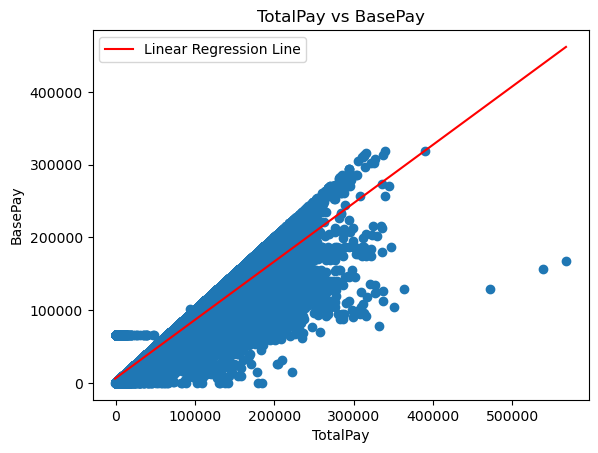

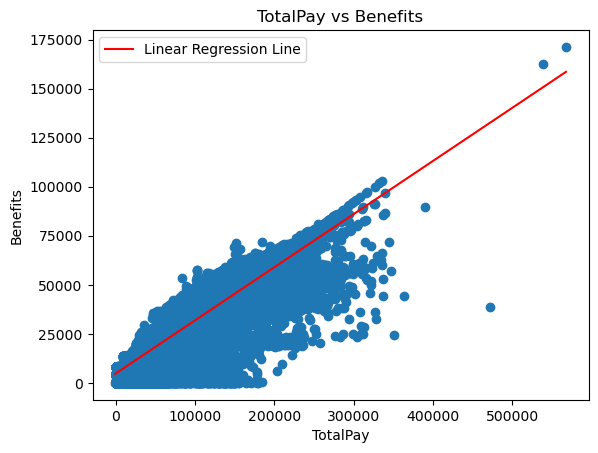

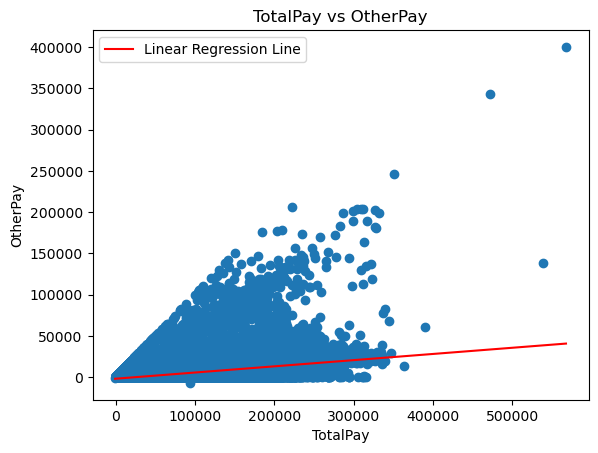

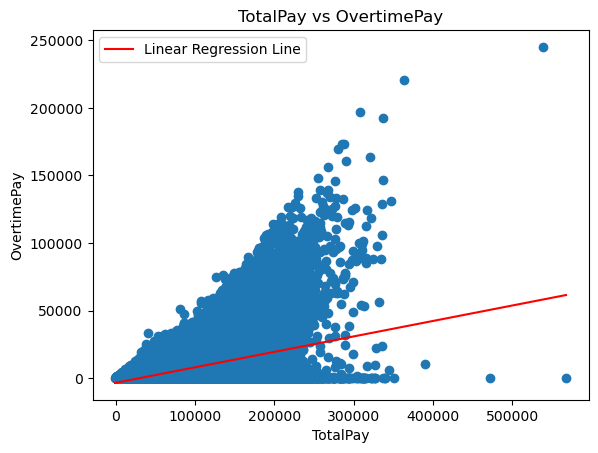

In [86]:
def sctplot(x: pd.Series):
    """
    Create a scatter plot with a linear regression line between 'TotalPay' and the specified column 'x'.

    Parameters:
    - x: DataFrame column to be plotted against 'TotalPay'.

    Returns:
    None
    """
    # Scatter plot of 'TotalPay' against the specified column 'x'
    plt.scatter(df.TotalPay, x)

    # Perform linear regression and plot the regression line
    m, b = np.polyfit(df.TotalPay, x, 1)
    plt.plot(df.TotalPay, m * df.TotalPay + b, color='red', label='Linear Regression Line')

    # Set plot title and axis labels
    plt.title("TotalPay vs " + x.name)
    plt.xlabel("TotalPay")
    plt.ylabel(x.name)

    plt.legend()
    plt.show()

# Loop through specified columns and create scatter plots for each
for x in ["BasePay", "Benefits", "OtherPay", "OvertimePay"]:
    sctplot(df[x])


### 7. Summary of Insights: Write a brief report summarizing the findings and insights from the analyses.

Further investigation into the data sources and collection process is needed, as some columns are missing. Notably, a maximum salary of 567,595.43 was observed, and the salary distribution displays a right-skewed bimodal pattern. The majority of employees hold the position of Transit Operator, and interestingly, the BasePay appears consistent over the four years. The highest salary, $567,595.43, was recorded in 2011. Additionally, there is an apparent increase in the hiring rate over the four years. Correlation calculations reveal a positive influence of BasePay, Benefits, OtherPay, and OvertimePay on overall salary. In conclusion, the data analysis suggests notable trends and patterns, highlighting the need for further exploration.